# Deep Learning : 3D shapes




## Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=500,precision=2,suppress=True)
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error


from IPython.display import clear_output

2023-02-03 15:00:05.870668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utils

In [2]:
def progression(i, n):
    i += 1
    k = int(i/n*20)
    print(f'\rProgression:[{k*"#"}{(20-k)*" "}] [{(i/n*100):.0f} %]',
          end='' if i != n else "\n", flush=True)

In [3]:
def plot_loss_acc(history):

    fig, axs = plt.subplots(1,2,figsize=(15,4))
    axs[0].set_title("Loss")
    axs[0].plot(history.history['loss'], label='loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].set_xlabel('Epoch #')
    axs[0].legend()

    axs[1].set_title("Accuracy")
    axs[1].plot(history.history['accuracy'], label='accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].set_xlabel('Epoch #')
    axs[1].legend();

In [4]:
def plot_test_pred(Y_test, Y_pred, titles) :

    n = Y_pred.shape[-1]

    

    if n<=2 :
      if n == 2 :
        fig, axs = plt.subplots(1,2, figsize=(7*n,4))
        for i in range(n) :
            axs[i].set_title(titles[i])
            axs[i].scatter(Y_test[:,i], Y_pred[:,i], alpha=0.1)
            abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
            axs[i].plot(abscisse, abscisse, 'k')
            axs[i].set_xlabel('Test')
            axs[i].set_ylabel('Pred')
      if n== 1 :
          fig, axs = plt.subplots(1,1, figsize=(10,4))
          axs.set_title(titles[0])
          axs.scatter(Y_test[:,0], Y_pred[:,0], alpha=0.1)
          abscisse=np.linspace(0,np.max(Y_test[:,0]),1000)
          axs.plot(abscisse, abscisse, 'k')
          axs.set_xlabel('Test')
          axs.set_ylabel('Pred')

    else :
      fig, axs = plt.subplots( (n+1)//2,2, figsize=(14, 3*n))
      for i in range(n) :
          axs[i//2, i%2].set_title(titles[i])
          axs[i//2, i%2].scatter(Y_test[:,i], Y_pred[:,i], alpha=0.1)
          abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
          axs[i//2, i%2].plot(abscisse, abscisse, 'k')
          axs[i//2, i%2].set_xlabel('Test')
          axs[i//2, i%2].set_ylabel('Pred')
    plt.tight_layout();

In [5]:
def plot_test_pred_corr(Y_test, Y_pred, titles, Corr, corr_label) :

    n = Y_pred.shape[-1]

    if n<=2 :
        if n == 2 :
            fig, axs = plt.subplots(1,2, figsize=(7*n,4))
            for i in range(n) :
                axs[i].set_title(titles[i])
                im = axs[i].scatter(Y_test[:,i],Y_pred[:,i],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
                abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
                axs[i].plot(abscisse, abscisse, 'k')
                axs[i].set_xlabel('Test')
                xs[i].set_ylabel('Pred')
                divider = make_axes_locatable(axs)
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
                
        if n== 1 :
            fig, axs = plt.subplots(1,1, figsize=(10,4))
            axs.set_title(titles[0])
            im = axs.scatter(Y_test[:,0],Y_pred[:,0],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
            abscisse=np.linspace(0,np.max(Y_test[:,0]),1000)
            axs.plot(abscisse, abscisse, 'k')
            axs.set_xlabel('Test')
            axs.set_ylabel('Pred')
            divider = make_axes_locatable(axs)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
    else :
        fig, axs = plt.subplots( (n+1)//2,2, figsize=(14, 3*n))
        for i in range(n) :
            xs[i//2, i%2].set_title(titles[i])
            im = axs[i//2, i%2].scatter(Y_test[:,i],Y_pred[:,i],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
            abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
            axs[i//2, i%2].plot(abscisse, abscisse, 'k')
            axs[i//2, i%2].set_xlabel('Test')
            axs[i//2, i%2].set_ylabel('Pred')
            divider = make_axes_locatable(axs[i//2, i%2])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
    plt.tight_layout();

## Data

### Import

In [6]:
catalog='../Data/ImageCat.txt'
filename=np.genfromtxt(catalog,skip_header=1,dtype='U60',usecols=0)
data=np.genfromtxt(catalog,skip_header =1, usecols=[1,2,3,4,5,6,7])  #filename	log(M/M_sun)	r_2/kpc	n	q=b/a	p=c/b	phi/pi	theta/pi

In [7]:
data.shape, data[0,:]

((10120, 7), array([10.  ,  0.1 ,  1.01,  0.19,  0.38,  0.46,  0.29]))

### Treatment

In [8]:
logM = np.copy(data[:,0])
R    = np.copy(data[:,1])
n    = np.copy(data[:,2])
q    = np.copy(data[:,3])
p    = np.copy(data[:,4])
phi  = np.copy(data[:,5])
theta= np.copy(data[:,6])

R4  = R/4.
n10 = n/10.

In [9]:
Y = np.stack([R4, n10, q, p, phi, theta],axis=1)
Y = Y.astype('float32')

Y_without_norm = np.stack([R, n, q, p, phi, theta],axis=1)
Y_without_norm = Y_without_norm.astype('float32')
Y.shape, Y.dtype

((10120, 6), dtype('float32'))

In [10]:
D1 = np.load('../Data/IMAGE/'+ filename[1])['imT']
D1.shape

(100, 100)

In [11]:
size = Y.shape[0] 
Y = Y[:size]
D=np.zeros((size,D1.shape[0],D1.shape[0],1)) 
for i in range(size):

    Di=np.load('../Data/IMAGE/'+ filename[i])  
    imTi=np.log10(Di['imT'])
    imTi_min=imTi[imTi>0.].min()
    imTi_max=np.amax(imTi)
    imTi[imTi<0.]=imTi_min
    D[i,:,:,0]=imTi

D = D.astype('float32') 


ngal=np.shape(D)[0]
print("The catalog comprises %i galaxies"%ngal)

The catalog comprises 10120 galaxies


### Plot one galaxy

[0.04 0.19 0.23 0.12 0.35 0.33]


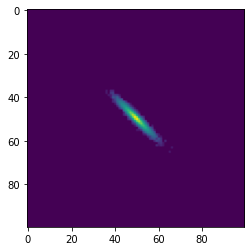

In [12]:
i=1000
print(Y[i,:])
plt.imshow(D[i,:,:,0]) 
plt.show()


### Spherical

In [15]:
rho0 = 1
ngal = len(n)
#Rc = 1

sigma = np.zeros((ngal, 100, 100))

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
z = np.linspace(-1, 1, 100)

X_, Y_ = np.meshgrid(x, y) 

for i in range(ngal) :
    progression(i,ngal)
    for j in range(100) :
        sigma[i][:][:] = sigma[i][:][:] + rho0 * np.exp( -2*n[i] * (np.sqrt(X_**2 + Y_**2 + z[j]**2)/R[i])**(1/n[i]) )

In [16]:
sigma = sigma.astype('float32') 
sigma = sigma[:,:,:,None]

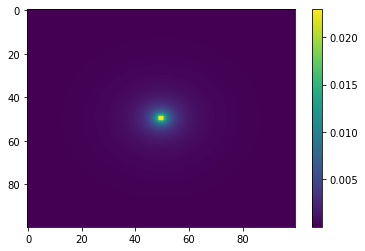

In [17]:
fig, ax = plt.subplots()
im=plt.imshow(sigma[90,:,:,0], aspect = 'auto')
plt.colorbar(im)
plt.show()

## Trainers

In [13]:
def R_2(y, y_pred):
    residual = tf.reduce_sum((y - y_pred)**2)
    total = tf.reduce_sum((y - tf.reduce_mean(y))**2)
    return 1.0 -residual / (total+1e-6)

In [14]:
def R_abs(y, y_pred): #Score pour la regression
    residual = tf.reduce_sum(tf.abs(y - y_pred))
    total = tf.reduce_sum(tf.abs(y - tf.reduce_mean(y)))
    return tf.clip_by_value(1.0 - residual / (total+1e-6),-2,1)

In [15]:
class Trainer :

    def __init__(self, X, Y, model, batch_size, learning_rate=1e-3) :

        self.model=model
        self.batch_size = batch_size

        l=len(X)
        train_size = int(0.7 * l)
        val_size = int(0.15 * l)

        self.X_train = X[:train_size]
        self.X_val   = X[train_size:train_size+val_size]
        self.X_test  = X[train_size+val_size:]

        self.Y_train = Y[:train_size]
        self.Y_val   = Y[train_size:train_size+val_size]
        self.Y_test  = Y[train_size+val_size:]

        self.data_train=tf.data.Dataset.from_tensor_slices((self.X_train,self.Y_train)).batch(batch_size)
        self.data_val=tf.data.Dataset.from_tensor_slices((self.X_val,self.Y_val)).batch(batch_size)
        self.data_test=tf.data.Dataset.from_tensor_slices((self.X_test,self.Y_test)).batch(batch_size)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.loss_fn= lambda y_true, y_pred : tf.reduce_mean((y_true-y_pred)**2)   
        self.acc_fn=R_2

        self.epoch = -1
        self.step = -1

        self.val_step_ind=[]
        self.train_losses = []
        self.train_acc    = []
        self.val_losses = []
        self.val_acc    = []

    


    @tf.function
    def train_step(self,x,y):

        with tf.GradientTape() as tape:
            pred = self.model(x,training=True)
            loss = self.loss_fn(y,pred)

        acc = self.acc_fn(y, pred)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return loss, acc

      
    
    def train(self, minutes) :

        start = time.time()

        try:
            OK=True
            while OK :
                self.epoch+=1 
                for x,y in self.data_train :
                    self.step+=1

                    loss, acc = self.train_step(x,y)
                    loss = loss.numpy()
                    acc = acc.numpy()
                    self.train_losses.append(loss)
                    self.train_acc.append(acc)

                
                
                OK = (time.time() - start) < minutes*60
                
            
                self.validation()

        except KeyboardInterrupt :
            pass
        
        self.validation()
        print(f"nombre d'époque réalisée : {self.epoch}")
        fig, (ax0,ax1) = plt.subplots(2, 1, sharex="all")
        ax0.plot(self.train_losses,label="train_loss")
        ax0.plot(self.val_step_ind,self.val_losses,label="val_loss")
        ax0.set_yscale("log")
        ax0.legend()

        ax1.plot(self.val_step_ind,self.val_acc,label="val_step")
        ax1.legend()
        plt.show()
    

    def validation(self) :

        los,acs=[],[]
        for x,y in self.data_val:
            pred = self.model(x, training = False)
            val_loss = self.loss_fn(y, pred)
            val_acc = self.acc_fn(y, pred)
            los.append(val_loss.numpy())
            acs.append(val_acc.numpy())
      
        Los, Acs = np.mean(los),np.mean(acs)
        

        self.val_losses.append(Los)
        self.val_acc.append(Acs)
        self.val_step_ind.append(self.step)

        if len(self.val_losses)> 1 and val_loss <= max(self.val_losses) :
            self.best_weights = self.model.get_weights
        

        clear_output(wait=True)
        print(f"Validation: step:{self.step}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}")
    


    def test(self):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
        

        los,acs=[],[]
        for x,y in self.data_test:
            pred = self.model(x, training = False)
            val_loss = self.loss_fn(y, pred)
            val_acc = self.acc_fn(y, pred)
            los.append(val_loss.numpy())
            acs.append(val_acc.numpy())
        
        test_loss, test_acc =np.mean(los),np.mean(acs)
        print(f"Test_loss:{test_loss:.5f}, test_acc:{test_acc:.3f}")

        return test_acc
        




Validation: step:11954, val_loss:0.000, val_acc:1.000
nombre d'époque réalisée : 3984


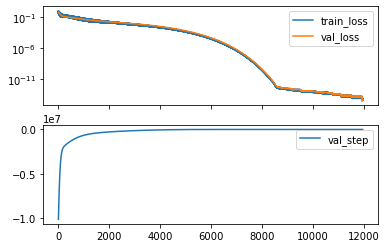

In [16]:
#Test the trainer with regression
def test_regression():
    X=tf.random.uniform([100,10,1])
    Y=tf.ones([100,1])
    model=tf.keras.Sequential([tf.keras.layers.Flatten(),tf.keras.layers.Dense(1)])
    trainer=Trainer(X,Y,model,batch_size=32)
    trainer.train(0.5)

test_regression()

## Models

### Model 1 : Convolution

In [17]:
class Model1(tf.keras.Model):

    def __init__(self, dimout):
        super().__init__()
        self.layer1=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')
        #self.dropout1=tf.keras.layers.Dropout(0.25)
        self.layer2=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer3=tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')
        self.layer4=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer5=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')

        self.flatten=tf.keras.layers.Flatten()
        self.dense1=tf.keras.layers.Dense(1024,activation='relu')
        self.dense2=tf.keras.layers.Dense(512,activation='relu')
        self.dense3=tf.keras.layers.Dense(dimout)
        print(f"Dim out = {dimout}")

        self.max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))


    @tf.function
    def call(self,X,training=True):

        out=self.layer1(X)
        #out=self.dropout1(out, training)
        out=self.max_pool(out)
        out=self.layer2(out)
        out=self.max_pool(out)
        out=self.layer3(out)
        out=self.max_pool(out)
        out=self.layer4(out)
        out=self.max_pool(out)
        out=self.layer5(out)
        out=self.max_pool(out)

        out=self.flatten(out)

        out=self.dense1(out)
        out=self.dense2(out)
        
        return self.dense3(out)



In [18]:
model1_test = Model1(1)
model1_test(tf.ones((20,64,64,1))).shape

Dim out = 1


TensorShape([20, 1])

In [19]:
model1_test.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  320       
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  73792     
                                                                 
 conv2d_4 (Conv2D)           multiple                  18464     
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  13209

### Model 2 : Unet

In [24]:
class Unet_4levels:
    
    def __init__(self,depth, dimout):
        self.depth=depth
        self.flatten=tf.keras.layers.Flatten()
        self.dense1=tf.keras.layers.Dense(2048,activation='relu')
        self.dense2=tf.keras.layers.Dense(1024,activation='relu')
        self.dense3=tf.keras.layers.Dense(dimout)
        print(f"Dim out = {dimout}")
                        
    def twoConvolutions(self, Y, depth,name):         
        Y = tf.keras.layers.Conv2D(depth, 5, activation="relu", padding='same',name=name+"_A")(Y)       
        Y = tf.keras.layers.Conv2D(depth, 5, activation="relu", padding='same',name=name+"_B")(Y)
        return Y
  
    def construct(self,inputs):

        conv_1 = self.twoConvolutions(inputs,self.depth,name="conv_1")   

        down_1 = tf.keras.layers.MaxPooling2D(name="down_1")(conv_1)              
        conv_2 = self.twoConvolutions(down_1,self.depth*2,name="conv_2") 

        down_2 = tf.keras.layers.MaxPooling2D(name="down_2")(conv_2)              
        conv_3 = self.twoConvolutions(down_2,self.depth*4,name="conv_3") 

        up_1 = tf.keras.layers.UpSampling2D(name="up_1")(conv_3)
        Y = tf.keras.layers.concatenate([conv_2, up_1], axis=3)
        conv_4 = self.twoConvolutions(Y, self.depth*2, name="conv_4")

        up_2 =  tf.keras.layers.UpSampling2D(name="up_2")(conv_4)                 
        Y = tf.keras.layers.concatenate([conv_1, up_2], axis=3)                   
        conv_5 = self.twoConvolutions(Y,self.depth,name="conv_5")   

        out = self.flatten(conv_5)

        #down_3 = tf.keras.layers.MaxPooling2D(name="down_3")(conv_3)             
        #conv_4 = self.twoConvolutions(down_3,self.depth*8,name="conv_4") 

        #up_1 =  tf.keras.layers.UpSampling2D(name="up_1")(conv_4)               
        #Y = tf.keras.layers.concatenate([conv_3, up_1], axis=3)                   
        #conv_5 = self.twoConvolutions(Y,self.depth*4,name="conv_5")      

        #up_2 =  tf.keras.layers.UpSampling2D(name="up_2")(conv_5)                 
        #Y = tf.keras.layers.concatenate([conv_2, up_2], axis=3)                   
        #conv_6 = self.twoConvolutions(Y,self.depth*2,name="conv_6")      

        #up_3 =  tf.keras.layers.UpSampling2D(name="up_3")(conv_6)                 
        #Y = tf.keras.layers.concatenate([conv_1, up_3], axis=3)                   
        #conv_7 = self.twoConvolutions(Y,self.depth,name="conv_7")   
        
        #out=self.flatten(conv_7)

        out=self.dense1(out)
        out=self.dense2(out)
        
        return self.dense3(out)



In [19]:
def make_Unet_4levels(width,dimout, window_width, nb_input):
    uNet=Unet_4levels(width, dimout)
    inputs= tf.keras.Input(shape=(window_width, window_width, nb_input))
    outputs= uNet.construct(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
#données fictives
nb_input=1
window_width=100

model=make_Unet_4levels(1,1,window_width, nb_input)

model.summary()

Dim out = 1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_A (Conv2D)              (None, 100, 100, 1)  26          ['input_1[0][0]']                
                                                                                                  
 conv_1_B (Conv2D)              (None, 100, 100, 1)  26          ['conv_1_A[0][0]']               
                                                                                                  
 down_1 (MaxPooling2D)          (None, 50, 50, 1)    0           ['conv_1_B[0][0]'

## Tests

In [27]:
#créer une fonction avec fit dedans et le nom du checkpoint_filepath

In [19]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

[0.14 0.58 0.15 0.18 0.27 0.28]


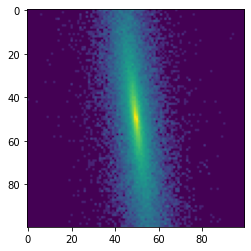

In [20]:
#Relancer plusieurs fois la cellule pour voir que l'on permute aléatoirement les données
shuffle= np.arange(D.shape[0])
np.random.shuffle(shuffle)

Y = Y[shuffle]
D = D[shuffle]
#sigma = sigma[shuffle]

print(Y[100])
plt.imshow(D[100,:,:,0]);

In [21]:
res_data = pd.DataFrame()

l = len(D)
train_size = int(0.7 * l)
val_size = int(0.15 * l)

X_train = D[:train_size]
#X_spher_train = sigma[:train_size]
Y_train = Y[:train_size]
Y_train_without_norm = Y_without_norm[:train_size]

X_val = D[train_size:train_size+val_size]
#X_spher_val = sigma[train_size:train_size+val_size]
Y_val = Y[train_size:train_size+val_size]
Y_val_without_norm = Y_without_norm[train_size:train_size+val_size]

X_test = D[train_size+val_size:]
#X_spher_test = sigma[train_size+val_size:]
Y_test = Y[train_size+val_size:]
Y_test_without_norm = Y_without_norm[train_size+val_size:]

#Y_train.shape, Y_val.shape, Y_test.shape, X_spher_train.shape, X_train.shape, X_spher_val.shape

### Parameter n

#### With normalization

##### Initial

In [22]:
Y_train_n = Y_train[:,1]
Y_train_n = Y_train_n[:, None]

Y_val_n = Y_val[:, 1]
Y_val_n = Y_val_n[:, None]

Y_test_n = Y_test[:, 1]
Y_test_n = Y_test_n[:, None]

Y_train_n.shape, Y_val_n.shape, Y_test_n.shape

((7084, 1), (1518, 1), (1518, 1))

In [ ]:
model1 = Model1(1)

model1.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

batch_size = 64
nb_epoch = 100

history = model1.fit(X_train, Y_train_n,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_n),
    callbacks=[model_checkpoint_callback])


model1.load_weights(checkpoint_filepath)


# Save the weights
model1.save_weights('./checkpoints/my_checkpoint')

In [30]:
plot_loss_acc(history)

In [31]:
Y_pred_n = model1(X_test)
Y_pred_n.shape

TensorShape([1518, 1])

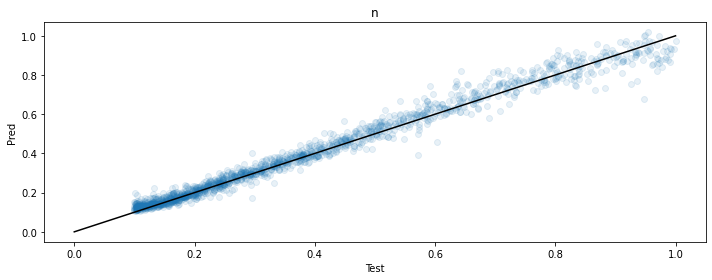

In [36]:
plot_test_pred(Y_test_n, Y_pred_n, ["n"])
#plt.savefig('pred_n.png', dpi=100)

##### Test on trained NN with noisy data

In [32]:
import random

def noisy_data(data, SNR) :
    data_noisy = np.copy(data)
    for i in range(data.shape[0]) :
        max_int = np.max(data[i])
        noise = np.random.normal(0, 1, (data.shape[1], data.shape[2]))
        noise = noise / np.max(noise) * max_int/SNR
        data_noisy[i] = data[i] + np.reshape(noise, (data.shape[1], data.shape[2],1))
    return data_noisy
    

In [35]:
SNR = 10
X_test_noisy = noisy_data(X_test, SNR)

Y_pred_n_noisy = model1(X_test_noisy)
Y_pred_n_noisy.shape

TensorShape([1518, 1])

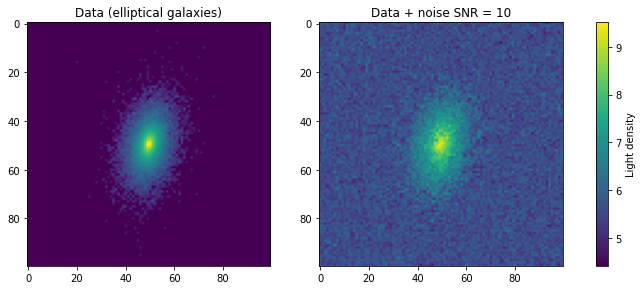

In [41]:
fig, ax =  plt.subplots(1,2, figsize = (12,10))

im = ax[0].imshow(X_test[50,:,:,0])
ax[0].set_title("Data (elliptical galaxies)")

im = ax[1].imshow(X_test_noisy[50,:,:,0])
ax[1].set_title("Data + noise SNR = %s"%(SNR))

fig.colorbar(im, ax=ax, orientation='vertical', label='Light density',  shrink=0.45)

#plt.savefig('images/noisy/comparison_data_SNR_10.png', dpi=100)

Text(0.1, 0.9, 'RMSE : 0.12')

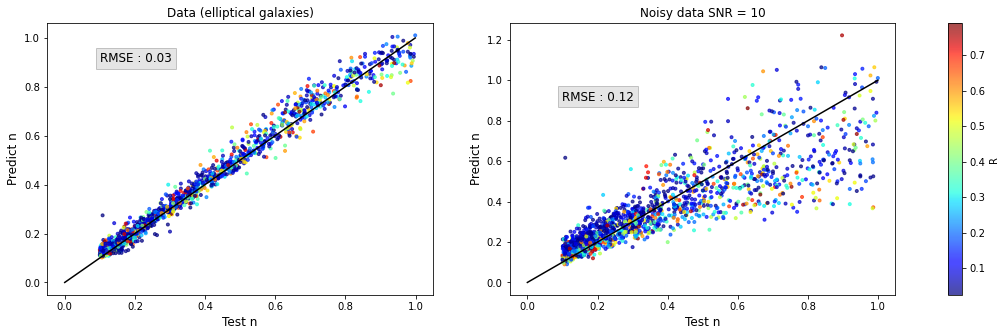

In [42]:
fig, ax =  plt.subplots(1,2, figsize = (19,5))

ax[0].set_title("Data (elliptical galaxies)", size=12)
im = ax[0].scatter(Y_test_n[:,0],Y_pred_n[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='.',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test n', size=12)
ax[0].set_ylabel('Predict n', size=12)
fig.colorbar(im, ax=ax, orientation='vertical', label='R')
ax[0].text(0.1, 0.9, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n, Y_pred_n)),2), fontsize=12,
           bbox=dict(facecolor='grey', alpha=0.2))

ax[1].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[1].scatter(Y_test_n[:,0],Y_pred_n_noisy[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test n', size=12)
ax[1].set_ylabel('Predict n', size=12)
ax[1].text(0.1, 0.9, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy)),2), fontsize=12,
          bbox=dict(facecolor='grey', alpha=0.2))


#plt.savefig('images/noisy/corr_comp_noisy_2.png',dpi=100)

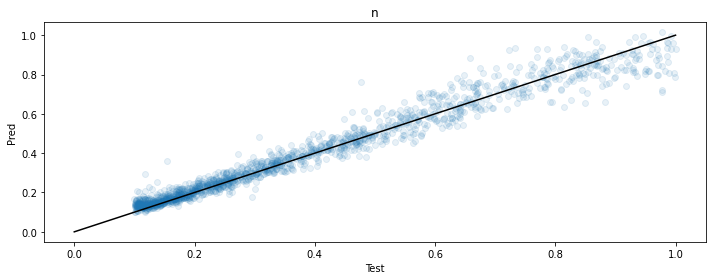

In [98]:
plot_test_pred(Y_test_n, Y_pred_n_noisy, ["n"])
#plt.savefig('n_pred_noisy_SNR_50.png', dpi=100)

#### Training on noisy data

In [44]:
SNR = 5
X_train_noisy = noisy_data(X_train, SNR)
X_val_noisy = noisy_data(X_val, SNR)
X_test_noisy = noisy_data(X_test, SNR)

In [45]:
noisy_checkpoint_filepath = '/tmp/noisy_checkpoint_SNR_5'
noisy_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=noisy_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model1_noisy = Model1(1)

model1_noisy.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

batch_size = 64
nb_epoch = 50

history = model1_noisy.fit(X_train_noisy, Y_train_n,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val_noisy, Y_val_n),
    callbacks=[noisy_model_checkpoint_callback])


model1_noisy.load_weights(noisy_checkpoint_filepath)


# Save the weights
model1_noisy.save_weights('./noisy_checkpoints_SNR_5/my_noisy_checkpoint_5')

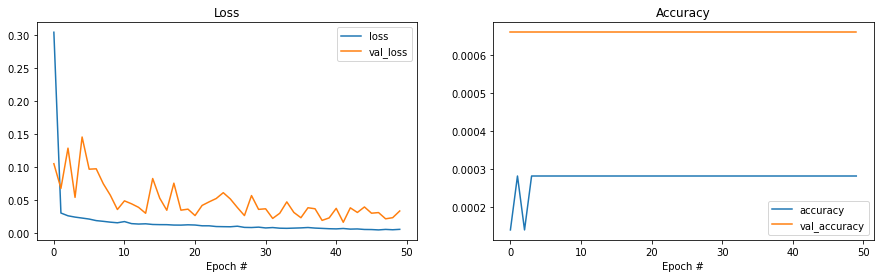

In [175]:
plot_loss_acc(history)
#plt.savefig('history_noisy_training_SNR_5.png', dpi=100)

In [48]:
Y_pred_n_noisy = model1_noisy(X_test_noisy)

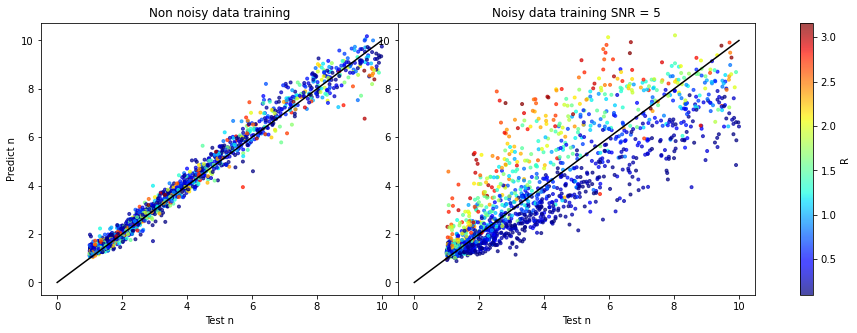

In [49]:
fig, ax =  plt.subplots(1,2, figsize = (16,5))

ax[0] = plt.subplot2grid((1, 2), (0, 0), colspan=1)
ax[0].set_title("Non noisy data training")
im = ax[0].scatter(Y_test_n[:,0]*10,Y_pred_n[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0])*10,1000)
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test n')
ax[0].set_ylabel('Predict n')

ax[1] = plt.subplot2grid((1, 2), (0, 1), colspan=1, sharey=ax[0])
ax[1].set_title("Noisy data training SNR = %s"%SNR)
im = ax[1].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test n')
#ax[1].set_yticklabels([])

plt.subplots_adjust(wspace=0)
fig.colorbar(im, ax=ax, orientation='vertical', label='R')

#plt.savefig('images/noisy/comp_noisy_data_train_5.png',dpi=100)

##### Spherical

In [ ]:
model1_spherical = Model1(1)

model1_spherical.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 30

history = model1_spherical.fit(X_spher_train, Y_train_n,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_spher_val, Y_val_n),
    callbacks=[model_checkpoint_callback])


model1_spherical.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_n_spherical = model1_spherical(X_spher_test)
Y_pred_n_spherical.shape

In [ ]:
plot_test_pred(Y_test_n, Y_pred_n_spherical, ["n"])

In [ ]:
plot_test_pred_corr(Y_test_n,Y_pred_n_spherical, ["n corr with R"], Y_test[:,0])

#### Without normalization

In [ ]:
Y_train_n_without_norm = Y_train_without_norm[:,1]
Y_train_n_without_norm = Y_train_n_without_norm[:, None]

Y_val_n_without_norm = Y_val_without_norm[:, 1]
Y_val_n_without_norm = Y_val_n_without_norm[:, None]

Y_test_n_without_norm = Y_test_without_norm[:, 1]
Y_test_n_without_norm = Y_test_n_without_norm[:, None]

Y_train_n_without_norm.shape, Y_val_n_without_norm.shape, Y_test_n_without_norm.shape

In [ ]:
model2 = Model1(1)

model2.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 30

history = model2.fit(X_train, Y_train_n_without_norm,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_n_without_norm),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_n_without_norm = model2(X_test)
Y_pred_n_without_norm.shape

In [ ]:
plot_test_pred(Y_test_n_without_norm, Y_pred_n_without_norm, ["n_without_norm"])

### Parameter R

#### Initial

In [43]:
Y_train_R = Y_train[:,0]
Y_train_R = Y_train_R[:, None]

Y_val_R = Y_val[:, 0]
Y_val_R = Y_val_R[:, None]

Y_test_R = Y_test[:, 0]
Y_test_R = Y_test_R[:, None]

Y_train_R.shape, Y_val_R.shape, Y_test_R.shape

((7084, 1), (1518, 1), (1518, 1))

In [44]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_R = Model1(1)

model_R.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

Dim out = 1


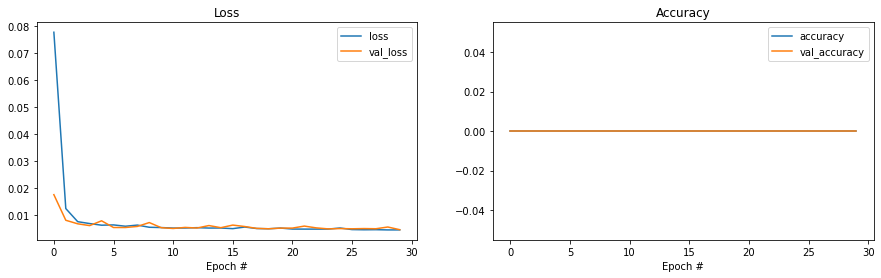

In [47]:
plot_loss_acc(history)
#plt.savefig('images/history_R.png', dpi=100)

In [48]:
# Save the weights
model_R.save_weights('./checkpoints/my_checkpoint_R100')

In [49]:
Y_pred_R = model_R(X_test)
Y_pred_R.shape

TensorShape([1518, 1])

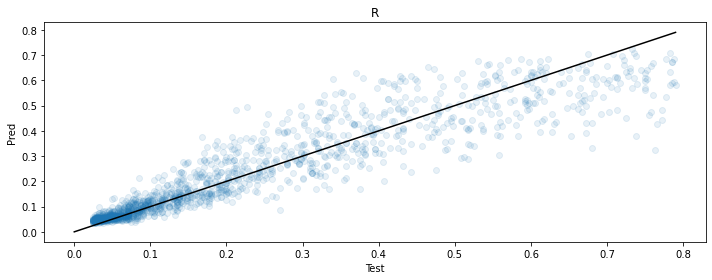

In [50]:
plot_test_pred(Y_test_R, Y_pred_R, ["R"])

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title("R corr with n")
axs[0].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,1],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title("R corr with q")
axs[1].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,2],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title("R corr with p")
axs[2].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,3],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"R corr with $\phi$")
axs[3].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,4],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"R corr with $\theta$")
axs[4].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,5],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

In [ ]:
plot_test_pred_corr(Y_test_R,Y_pred_R, ["R corr with R"], Y_test[:,0])

#### Spherical

In [ ]:
modelR_spherical = Model1(1)

modelR_spherical.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 70

history = modelR_spherical.fit(X_spher_train, Y_train_R,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_spher_val, Y_val_R),
    callbacks=[model_checkpoint_callback])


modelR_spherical.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_R_spherical = modelR_spherical(X_spher_test)
Y_pred_R_spherical.shape

In [ ]:
plot_test_pred(Y_test_R, Y_pred_R_spherical, ["R"])

In [ ]:
plot_test_pred_corr(Y_test_R,Y_pred_R_spherical, ["R corr with n"], Y_test[:,1])

### Parameter q

#### Initial

In [ ]:
Y_train_q = Y_train[:,2]
Y_train_q = Y_train_q[:, None]

Y_val_q = Y_val[:, 2]
Y_val_q = Y_val_q[:, None]

Y_test_q = Y_test[:, 2]
Y_test_q = Y_test_q[:, None]

Y_train_q.shape, Y_val_q.shape, Y_test_q.shape

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_q = Model1(1)

model_q.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 50

history = model_q.fit(X_train, Y_train_q,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_q),
    callbacks=[model_checkpoint_callback])


model_q.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_q = model_q(X_test)
Y_pred_q.shape

In [ ]:
plot_test_pred(Y_test_q, Y_pred_q, ["q"])

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title("q corr with R")
axs[0].scatter(Y_test_q[:,0],Y_pred_q[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_q[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title("q corr with n")
axs[1].scatter(Y_test_q[:,0],Y_pred_q[:,0],c=Y_test[:,1],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_q[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title("q corr with p")
axs[2].scatter(Y_test_q[:,0],Y_pred_q[:,0],c=Y_test[:,3],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_q[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"q corr with $\phi$")
axs[3].scatter(Y_test_q[:,0],Y_pred_q[:,0],c=Y_test[:,4],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_q[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"q corr with $\theta$")
axs[4].scatter(Y_test_q[:,0],Y_pred_q[:,0],c=Y_test[:,5],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_q[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

In [ ]:
plot_test_pred_corr(Y_test_q,Y_pred_q, ["q corr with q"], Y_test[:,2])

### Parameter p

#### Initial

In [ ]:
Y_train_p = Y_train[:,3]
Y_train_p = Y_train_p[:, None]

Y_val_p = Y_val[:, 3]
Y_val_p = Y_val_p[:, None]

Y_test_p = Y_test[:, 3]
Y_test_p = Y_test_p[:, None]

Y_train_p.shape, Y_val_p.shape, Y_test_p.shape

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_p = Model1(1)

model_p.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 50

history = model_p.fit(X_train, Y_train_p,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_p),
    callbacks=[model_checkpoint_callback])


model_p.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_p = model_p(X_test)
Y_pred_p.shape

In [ ]:
plot_test_pred(Y_test_p, Y_pred_p, ["p"])

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title("p corr with R")
axs[0].scatter(Y_test_p[:,0],Y_pred_p[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_p[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title("p corr with n")
axs[1].scatter(Y_test_p[:,0],Y_pred_p[:,0],c=Y_test[:,1],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_p[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title("p corr with q")
axs[2].scatter(Y_test_p[:,0],Y_pred_p[:,0],c=Y_test[:,2],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_p[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"p corr with $\phi$")
axs[3].scatter(Y_test_p[:,0],Y_pred_p[:,0],c=Y_test[:,4],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_p[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"p corr with $\theta$")
axs[4].scatter(Y_test_p[:,0],Y_pred_p[:,0],c=Y_test[:,5],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_p[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

In [ ]:
plot_test_pred_corr(Y_test_p,Y_pred_p, ["p corr with p"], Y_test[:,3])

### Parameter $\phi$

#### Initial

In [ ]:
Y_train_phi = Y_train[:,4]
Y_train_phi = Y_train_phi[:, None]

Y_val_phi = Y_val[:, 4]
Y_val_phi = Y_val_phi[:, None]

Y_test_phi = Y_test[:, 4]
Y_test_phi = Y_test_phi[:, None]

Y_train_phi.shape, Y_val_phi.shape, Y_test_phi.shape

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_phi = Model1(1)

model_phi.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 50

history = model_phi.fit(X_train, Y_train_phi,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_phi),
    callbacks=[model_checkpoint_callback])


model_phi.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_phi = model_phi(X_test)
Y_pred_phi.shape

In [ ]:
plot_test_pred(Y_test_phi, Y_pred_phi, ["$\phi$"])

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title("$\phi$ corr with R")
axs[0].scatter(Y_test_phi[:,0],Y_pred_phi[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_phi[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title("$\phi$ corr with n")
axs[1].scatter(Y_test_phi[:,0],Y_pred_phi[:,0],c=Y_test[:,1],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_phi[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title("$\phi$ corr with q")
axs[2].scatter(Y_test_phi[:,0],Y_pred_phi[:,0],c=Y_test[:,2],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_phi[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"$\phi$ corr with p")
axs[3].scatter(Y_test_phi[:,0],Y_pred_phi[:,0],c=Y_test[:,3],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_phi[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"$\phi$ corr with $\theta$")
axs[4].scatter(Y_test_phi[:,0],Y_pred_phi[:,0],c=Y_test[:,5],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_phi[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

In [ ]:
plot_test_pred_corr(Y_test_phi,Y_pred_phi, ["$\phi$ corr with $\phi$"], Y_test[:,4])

### Parameter $\theta$

#### Initial

In [ ]:
Y_train_theta = Y_train[:,5]
Y_train_theta = Y_train_theta[:, None]

Y_val_theta = Y_val[:, 5]
Y_val_theta = Y_val_theta[:, None]

Y_test_theta = Y_test[:, 5]
Y_test_theta = Y_test_theta[:, None]

Y_train_theta.shape, Y_val_theta.shape, Y_test_theta.shape

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_theta = Model1(1)

model_theta.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 50

history = model_theta.fit(X_train, Y_train_theta,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_theta),
    callbacks=[model_checkpoint_callback])


model_theta.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_theta = model_theta(X_test)
Y_pred_theta.shape

In [ ]:
plot_test_pred(Y_test_theta, Y_pred_theta, ["$\theta$"])

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title(r"$\theta$ corr with R")
axs[0].scatter(Y_test_theta[:,0],Y_pred_theta[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_theta[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title(r"$\theta$ corr with n")
axs[1].scatter(Y_test_theta[:,0],Y_pred_theta[:,0],c=Y_test[:,1],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_theta[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title(r"$\theta$ corr with q")
axs[2].scatter(Y_test_theta[:,0],Y_pred_theta[:,0],c=Y_test[:,2],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_theta[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"$\theta$ corr with p")
axs[3].scatter(Y_test_theta[:,0],Y_pred_theta[:,0],c=Y_test[:,3],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_theta[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"$\theta$ corr with $\phi$")
axs[4].scatter(Y_test_theta[:,0],Y_pred_theta[:,0],c=Y_test[:,4],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_theta[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

In [ ]:
plot_test_pred_corr(Y_test_theta,Y_pred_theta, [r"$\theta$ corr with $\theta$"], Y_test[:,5])

### Parameter n and R

#### With normalization

In [ ]:
Y_train_Rn = Y_train[:,0:2]

Y_val_Rn = Y_val[:, 0:2]

Y_test_Rn = Y_test[:, 0:2]

Y_train_Rn.shape, Y_val_Rn.shape, Y_test_Rn.shape

##### Model1

In [ ]:
model3 = Model1(2)

model3.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 30

history = model3.fit(X_train, Y_train_Rn,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_Rn),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_Rn = model3(X_test)
Y_pred_Rn.shape

In [ ]:
plot_test_pred(Y_test_Rn, Y_pred_Rn, ["R", "n"])

##### Unet

In [ ]:
window_width = D.shape[1]
nb_input = D.shape[-1]

model3_unet=make_Unet_4levels(1,2,window_width, nb_input)

In [ ]:
model3_unet.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 30

history = model3_unet.fit(X_train, Y_train_Rn,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_Rn),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_Rn = model3_unet(X_test)
Y_pred_Rn.shape

In [ ]:
plot_test_pred(Y_test_Rn, Y_pred_Rn, ["R", "n"])

##### Spherical

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model2_spherical = Model1(2)

model2_spherical.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 30

history = model2_spherical.fit(X_spher_train, Y_train_Rn,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_spher_val, Y_val_Rn),
    callbacks=[model_checkpoint_callback])


model2_spherical.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_Rn_spherical = model2_spherical(X_spher_test)
Y_pred_Rn_spherical.shape

In [ ]:
plot_test_pred(Y_test_Rn, Y_pred_Rn_spherical, ["R","n"])

#### Without normalization

In [ ]:
Y_train_Rn_without_norm = Y_train_without_norm[:,0:2]

Y_val_Rn_without_norm = Y_val_without_norm[:, 0:2]

Y_test_Rn_without_norm = Y_test_without_norm[:, 0:2]

Y_train_Rn_without_norm.shape, Y_val_Rn_without_norm.shape, Y_test_Rn_without_norm.shape

In [ ]:
model4 = Model1(2)

model4.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 30

history = model4.fit(X_train, Y_train_Rn_without_norm,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_Rn_without_norm),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_Rn_without_norm = model4(X_test)
Y_pred_Rn_without_norm.shape

In [ ]:
plot_test_pred(Y_test_Rn_without_norm, Y_pred_Rn_without_norm, ["R_without_norm", "n_without_norm"])

### Parameter q and p

In [ ]:
Y_train_qp = Y_train[:,2:4]

Y_val_qp = Y_val[:, 2:4]

Y_test_qp = Y_test[:, 2:4]

Y_train_qp.shape, Y_val_qp.shape, Y_test_qp.shape

In [ ]:
model5 = Model1(2)

model5.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
batch_size = 64
nb_epoch = 100

history = model5.fit(X_train, Y_train_qp,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_qp),
    callbacks=[model_checkpoint_callback])


model5.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_qp = model5(X_test)
Y_pred_qp.shape

In [ ]:
plot_test_pred(Y_test_qp, Y_pred_qp, ["q", "p"])

### Parameter n, R, q and p

In [ ]:
Y_train_nRqp = Y_train[:,0:4]

Y_val_nRqp = Y_val[:, 0:4]

Y_test_nRqp = Y_test[:, 0:4]

Y_train_nRqp.shape, Y_val_nRqp.shape, Y_test_nRqp.shape

In [ ]:
model6 = Model1(4)

model6.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
batch_size = 64
nb_epoch = 100

history = model6.fit(X_train, Y_train_nRqp,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_nRqp),
    callbacks=[model_checkpoint_callback])


model6.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_nRqp = model6(X_test)
Y_pred_nRqp.shape

In [ ]:
plot_test_pred(Y_test_nRqp, Y_pred_nRqp, ["R", "n", "q", "p"])

In [ ]:
#faire une classe qui permet de tester les différentes trucs sans faire 50 cellules -> faire un trainer avec fit ou epoch=1 et faire while pour le train duration

### Parameter $\phi$ et $\theta$

In [ ]:
Y_train_ΦΘ = Y_train[:,4:6]

Y_val_ΦΘ = Y_val[:, 4:6]

Y_test_ΦΘ = Y_test[:, 4:6]

Y_train_ΦΘ.shape, Y_val_ΦΘ.shape, Y_test_ΦΘ.shape

In [ ]:
model7 = Model1(2)

model7.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
batch_size = 64
nb_epoch = 100

history = model7.fit(X_train, Y_train_ΦΘ,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_ΦΘ),
    callbacks=[model_checkpoint_callback])


model7.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_ΦΘ = model7(X_test)
Y_pred_ΦΘ.shape

In [ ]:
plot_test_pred(Y_test_ΦΘ, Y_pred_ΦΘ, ["phi", "theta"])